In [1]:
!pip install pennylane-sf --upgrade

In [0]:
import numpy as np
import pennylane as qml
from pennylane import expval, var

In [0]:
dev = qml.device("default.qubit", wires=2)

def circuit(params, wires):
    qml.RY(params[0], wires=0)
    qml.RY(params[1], wires=1)

    qml.CNOT(wires=[0,1])

    qml.RY(params[2], wires=0)
    qml.RY(params[3], wires=1)

In [0]:
alpha = 0.4
beta = 0.2

obs_list = [
    qml.PauliZ(0) @qml.Identity(1),
    qml.Identity(0) @qml.PauliZ(1),
    qml.PauliX(0) @qml.PauliX(1)
]

qnodes = qml.map(circuit, obs_list, dev, measure='expval')
expval = qml.dot([alpha, alpha, beta], qnodes)

In [0]:
max_iterations = 200
conv_tol = 1e-06
step_size = 0.05

In [6]:
qng_cost = []
opt = qml.QNGOptimizer(stepsize=step_size)

params = np.array([-0.2,-0.2,0,0])
prev_energy = expval(params)
for n in range(max_iterations):

    # compute specific gradient of parameters
    gradient = qml.grad(expval, argnum=[0])
    grad_at_point = [float(i) for i in gradient(params)[0]]

    # manual qng step
    params = params - step_size * np.dot(
                np.linalg.pinv(qnodes[0].metric_tensor([params])), 
                grad_at_point)

    # update parameters
    energy = expval(params)
    qng_cost.append(energy)

    # calculate difference of new energy versus previous energy (ie, convergence)
    conv = np.abs(energy - prev_energy)

    if n % 20 == 0:
        print('Iteration = {:},  Ground-state energy = {:.8f} Ha,  Convergence parameter = {'
              ':.8f} Ha'.format(n, energy, conv))

    if conv <= conv_tol:
        break

    prev_energy = energy

print()
print('Final convergence parameter = {:.8f} Ha'.format(conv))
print('Final value of the ground-state energy = {:.8f} Ha'.format(energy))
print()
print('Final circuit parameters = \n', params)

Iteration = 0,  Ground-state energy = 0.76788358 Ha,  Convergence parameter = 0.00835525 Ha
Iteration = 20,  Ground-state energy = -0.45259351 Ha,  Convergence parameter = 0.04191113 Ha
Iteration = 40,  Ground-state energy = -0.77952721 Ha,  Convergence parameter = 0.00341175 Ha
Iteration = 60,  Ground-state energy = -0.79875061 Ha,  Convergence parameter = 0.00016558 Ha
Iteration = 80,  Ground-state energy = -0.79987177 Ha,  Convergence parameter = 0.00001460 Ha
Iteration = 100,  Ground-state energy = -0.79998451 Ha,  Convergence parameter = 0.00000171 Ha

Final convergence parameter = 0.00000091 Ha
Final value of the ground-state energy = -0.79999172 Ha

Final circuit parameters = 
 [-3.1412811  -1.09122843  0.00716478 -1.09647319]


In [9]:
params = np.array([-0.2,-0.2,0,0])
step_size = 0.05

vanilla_cost = []
opt = qml.GradientDescentOptimizer(stepsize=step_size)

prev_energy = expval(params)
for n in range(max_iterations):

    # compute gradient for the cost function
    gradient = qml.grad(expval, argnum=[0])

    # compute specific gradient of parameters
    grad_at_point = [float(i) for i in gradient(params)[0]]

    # manual qng step
    params = params - step_size * np.dot(step_size, grad_at_point)

    # update parameters
    energy = expval(params)
    vanilla_cost.append(energy)

    # calculate difference of new energy versus previous energy (ie, convergence)
    conv = np.abs(energy - prev_energy)

    if n % 20 == 0:
        print('Iteration = {:},  Ground-state energy = {:.8f} Ha,  Convergence parameter = {'
              ':.8f} Ha'.format(n, energy, conv))

    if conv <= conv_tol:
        break

    prev_energy = energy

print()
print('Final convergence parameter = {:.8f} Ha'.format(conv))
print('Final value of the ground-state energy = {:.8f} Ha'.format(energy))
print()
print('Final circuit parameters = \n', params)

Iteration = 0,  Ground-state energy = 0.77614209 Ha,  Convergence parameter = 0.00009674 Ha
Iteration = 20,  Ground-state energy = 0.77412284 Ha,  Convergence parameter = 0.00010488 Ha
Iteration = 40,  Ground-state energy = 0.77193393 Ha,  Convergence parameter = 0.00011368 Ha
Iteration = 60,  Ground-state energy = 0.76956171 Ha,  Convergence parameter = 0.00012319 Ha
Iteration = 80,  Ground-state energy = 0.76699161 Ha,  Convergence parameter = 0.00013344 Ha
Iteration = 100,  Ground-state energy = 0.76420802 Ha,  Convergence parameter = 0.00014450 Ha
Iteration = 120,  Ground-state energy = 0.76119431 Ha,  Convergence parameter = 0.00015642 Ha
Iteration = 140,  Ground-state energy = 0.75793273 Ha,  Convergence parameter = 0.00016925 Ha
Iteration = 160,  Ground-state energy = 0.75440446 Ha,  Convergence parameter = 0.00018305 Ha
Iteration = 180,  Ground-state energy = 0.75058951 Ha,  Convergence parameter = 0.00019788 Ha

Final convergence parameter = 0.00021296 Ha
Final value of the gr

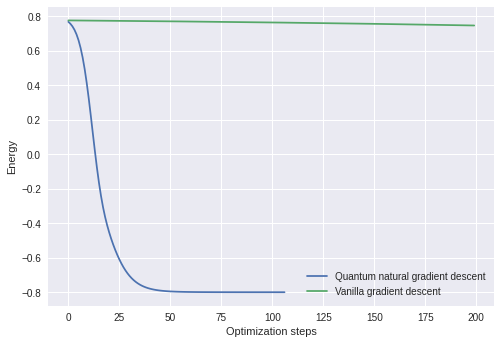

In [10]:
from matplotlib import pyplot as plt

plt.style.use("seaborn")
plt.plot(qng_cost, label="Quantum natural gradient descent")
plt.plot(vanilla_cost, label="Vanilla gradient descent")

plt.ylabel("Energy")
plt.xlabel("Optimization steps")
plt.legend()
plt.show()